<a href="https://colab.research.google.com/github/ReemAlsharabi/KAUST-Academy/blob/main/summer-program/week4/GNNs/05_GRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recurrent Graph Neural Networks: Hungarian ChickenPox Dataset

### Dataset information
The Hungarian Chicken pox dataset models an outbreak of chickenpox in Hungary during 2005-2015. Each node represents a county and the edges represent the spatial connectivity of the counties. The node features are the weekly chickenpox cases in the counties. The task is to predict the weekly chickenpox cases in the counties.

### Dataset description
The dataset consist of a single graph. The node features are the weekly chickenpox cases in the counties. The target is the weekly chickenpox cases in the counties. The dataset is split into a training, validation and test set by using the first 70% of the timesteps for training, the following 10% for validation and the last 20% for testing. For more details see [here](https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/dataset.html)

### Task description
The task is to predict the weekly chickenpox cases in the counties. The task is a regression task. The performance of the model will be evaluated using the Mean Squared Error (MSE) metric.

### Libraries and utilities used in the notebook
We will be using a Recurrent Graph Neural Network (GRNN) to model the temporal dynamics of the graph. The tools that will be used to implment GRNN are based on PyTorch Geometric Temporal (PyTorch Geometric Temporal (PyTorch Geometric Temporal: Spatiotemporal Signal Processing with Neural Machine Learning Models (2020). Authors: Shubhanshu Mishra, Soumya Sanyal, Johannes Klicpera, and Stephan Günnemann. [pytorch_geometric_temporal
](https://github.com/benedekrozemberczki/pytorch_geometric_temporal)).

The model that we will use is a DCRNN based model. The model is based on the paper: [Diffusion Convolutional Recurrent Neural Network: Data-Driven Traffic Forecasting](https://arxiv.org/abs/1707.01926). The model is a recurrent neural network that uses the graph structure of the data to model the temporal dynamics of the data. The model consists of a graph convolutional layer, a gated recurrent unit layer and a fully connected layer. The model is trained to minimize the mean squared error between the predicted and the actual target values.

## Software Libraries
You are likely running pytorch on cpu, so lets install some of the extra dependencies before we proceed with the pytorch geometric temporal library.


In [ ]:
# Install additional dependencies
# Install required packages
import os
import torch

os.environ['TORCH'] = torch.__version__
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_spline_conv -f https://data.pyg.org/whl/torch-${TORCH}.html

# Install pytorch geometric temporal
!pip install torch-geometric-temporal

Lets load the dataset of the Hungarian Chicken Pox outbreak from the pytorch Geometric temporal library


In [ ]:
import torch
import numpy as np
print("PyTorch has version {}".format(torch.__version__))

import torch_geometric
import torch_geometric_temporal
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader

from torch_geometric_temporal.signal import temporal_signal_split
print("PyTorch Geometric has version {}".format(torch_geometric.__version__))
print("PyTorch Geometric temporal has version {}".format(torch_geometric_temporal.__version__))

dataset_loader = ChickenpoxDatasetLoader()
dataset = dataset_loader.get_dataset()

PyTorch has version 2.0.1+cu118
PyTorch Geometric has version 2.4.0
PyTorch Geometric temporal has version 0.54.0


In [ ]:
# Split the dataset into train and test dataset with a ratio of 0.2 (20%)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

print('Train Dataset lenght ', len(train_dataset.features))
print('Test Dataset lenght ', len(test_dataset.features))


Train Dataset lenght  103
Test Dataset lenght  414


### Model design and training
The model consists of a graph convolutional layer, a gated recurrent unit layer and a fully connected layer. In this task, we cannot use the GCNconv because it will not capture the temporal dynamics of the data.

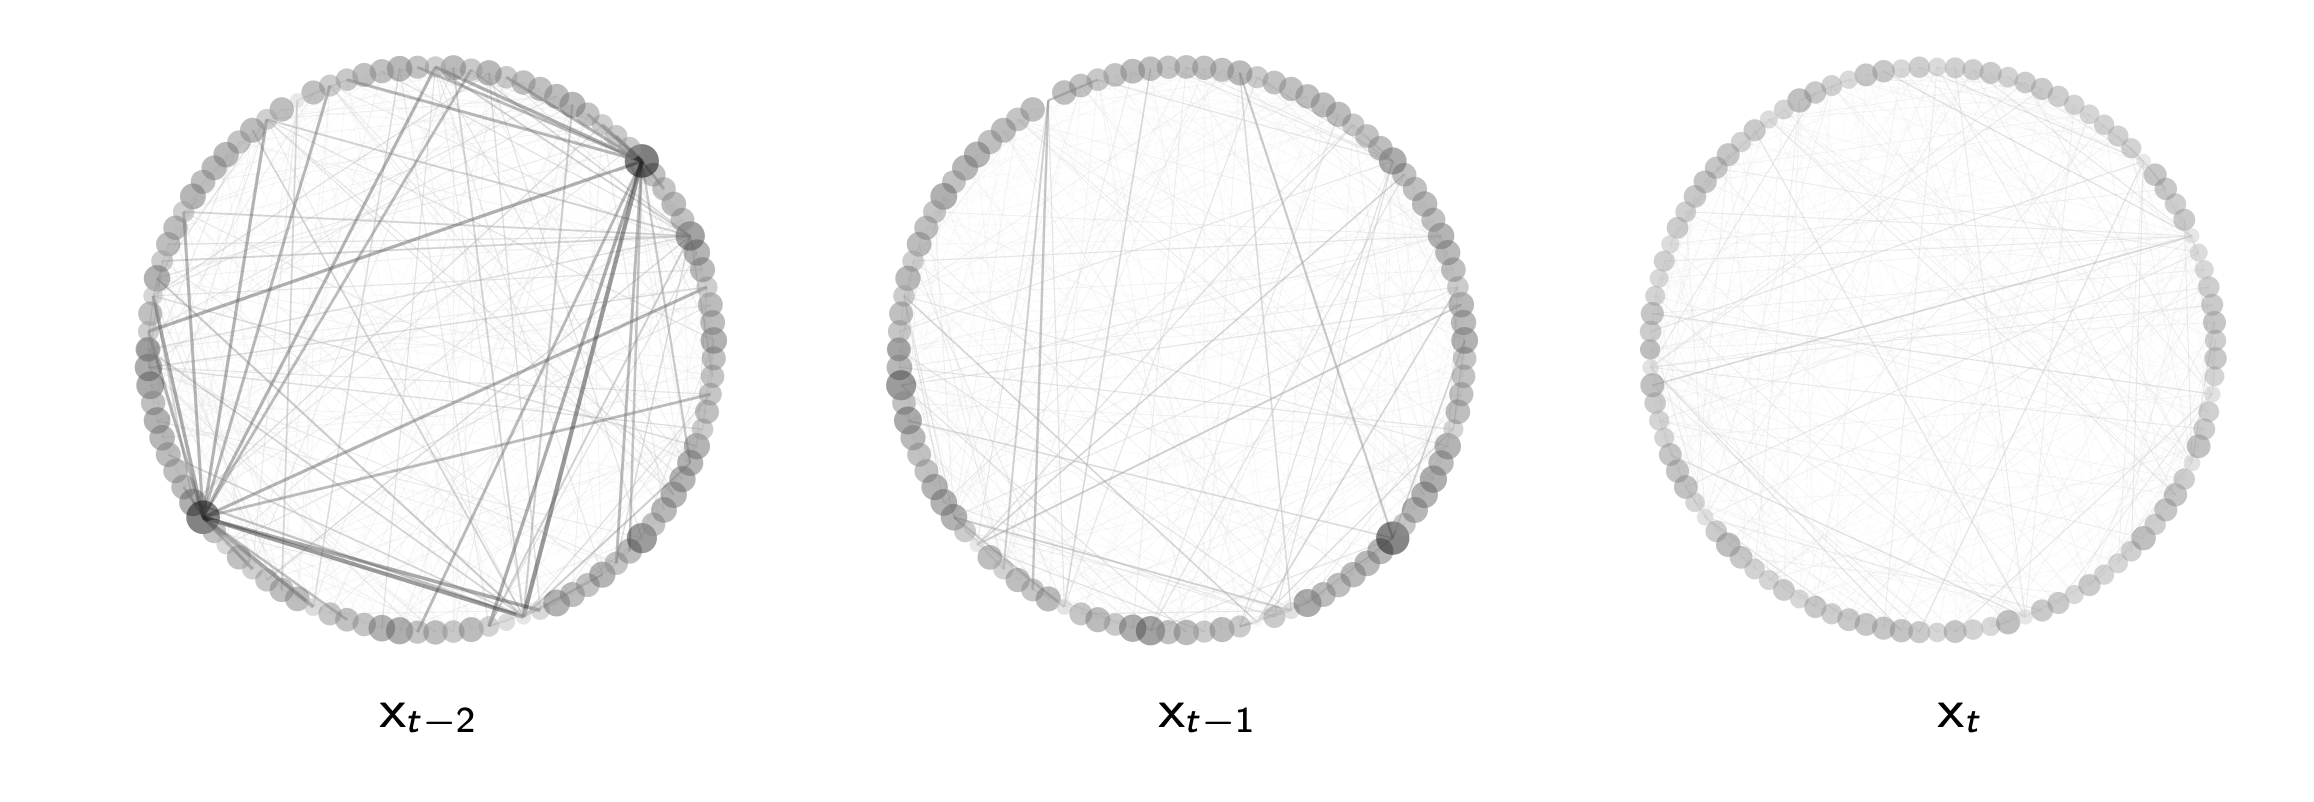

The Pytorch geometric temporal library offers various layers implmentation that can be used to build a recurrent graph neural network. A table that summarizes the layers and their properties is shown below.

| Model | $\begin{array}{c}\text { Temporal } \\\text { Layer }\end{array}$ | $\begin{array}{c}\text { GNN } \\\text { Layer }\end{array}$ | $\begin{array}{c}\text { Proximity } \\\text { Order }\end{array}$ | $\begin{array}{c}\text { Multi } \\\text { Type }\end{array}$ |
| :--- | :---: | :---: | :---: | :---: |
| DCRNN [32] | GRU | DiffConv | Higher | False |
| GConvGRU [51] | GRU | Chebyshev | Lower | False |
| GConvLSTM [51] | LSTM | Chebyshev | Lower | False |
| GC-LSTM [10] | LSTM | Chebyshev | Lower | True |
| DyGrAE [54, 55] | LSTM | GGCN | Higher | False |
| LRGCN [31] | LSTM | RGCN | Lower | False |
| EGCN-H [39] | GRU | GCN | Lower | False |
| EGCN-O [39] | LSTM | GCN | Lower | False |
| T-GCN [65] | GRU | GCN | Lower | False |
| A3T-GCN [68] | GRU | GCN | Lower | False |
| AGCRN [4] | GRU | Chebyshev | Higher | False |
| MPNN LSTM [38] | LSTM | GCN | Lower | False |
| STGCN [63] | Attention | Chebyshev | Higher | False |
| ASTGCN [22] | Attention | Chebyshev | Higher | False |
| MSTGCN [22] | Attention | Chebyshev | Higher | False |
| GMAN [66] | Attention | Custom | Lower | False |
| MTGNN [61] | Attention | Custom | Higher | False |
| AAGCN [52] | Attention | Custom | Higher | False |

The GConvGRU layer from the pytorch geometric temporal library is a graph convolutional layer followed by a gated recurrent unit layer. First, the graph convolutional layer is applied to the input data. Then, the gated recurrent unit layer is applied to the output of the graph convolutional layer.

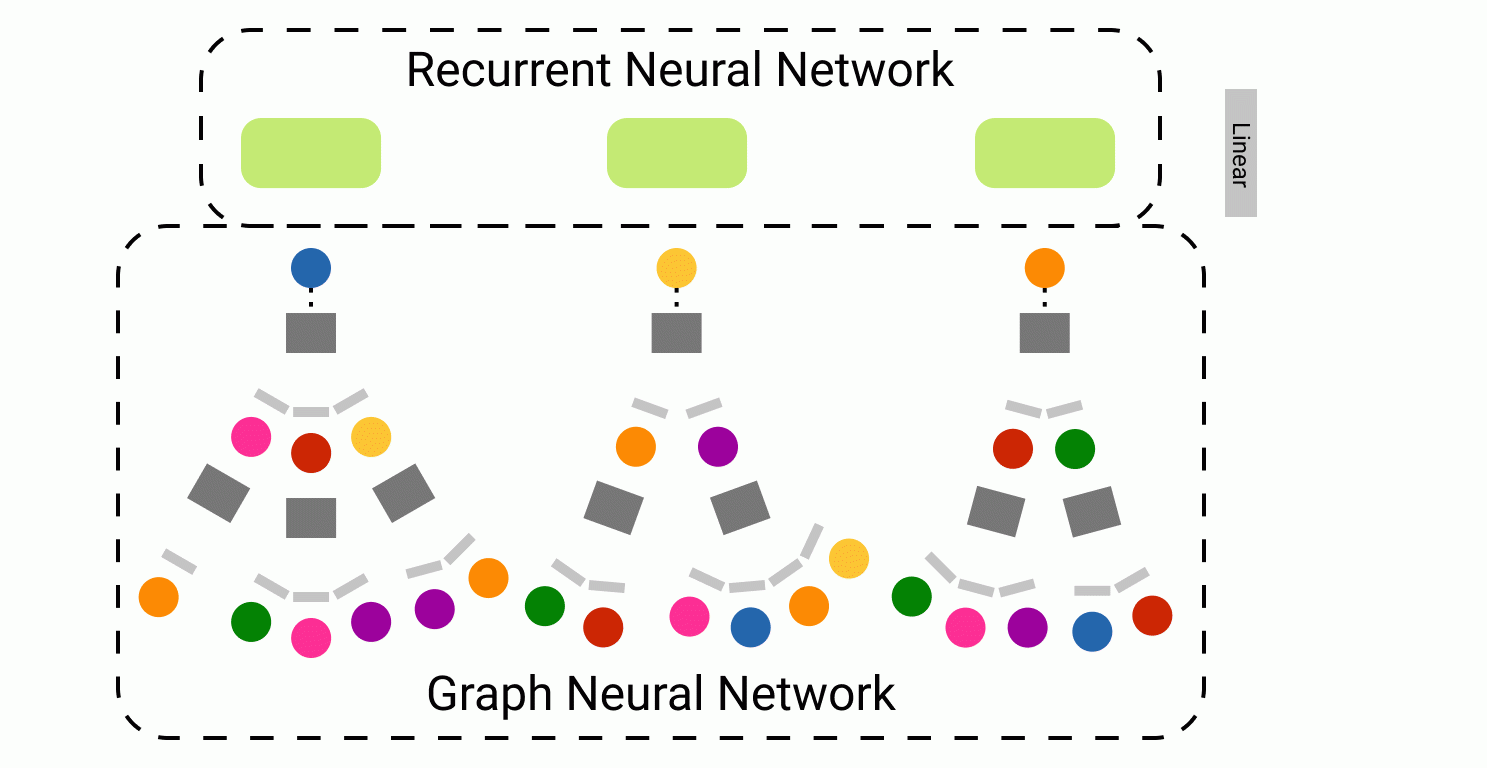

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, 32, 5) # 5 is the number of time steps
        self.linear = torch.nn.Linear(32, 1) # 1 is the number of targets (in this case the number of cases)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h


Lets train the network using the tqdm utility.

In [ ]:
from tqdm import tqdm

model = RecurrentGCN(node_features = 4) # 4 is the number of features per node
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
cost_array = []

for epoch in tqdm(range(100)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost_array.append(torch.mean((y_hat-snapshot.y)**2))
        cost = cost + torch.mean((y_hat-snapshot.y)**2) # Mean Squared Error
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


Finally we eval our trained model and its predictions.

In [ ]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))


MSE: 1.0462


## Exercise 1: Web Traffic Predection

### Dataset Description
We are using the Wikipedia Maths dataset in this case study. The underlying graph is static - vertices are Wikipedia pages and edges are links between them. The graph is directed and weighted. Weights represent the number of links found at the source Wikipedia page linking to the target Wikipedia page. The target is the daily user visits to the Wikipedia pages between March 16th 2019 and March 15th 2021 which results in 731 periods. We will train a recurrent graph neural network to predict the daily views on Wikipedia pages using a recurrent graph convolutional network.

### Task Description
We will train a recurrent graph neural network to predict the daily views on Wikipedia pages using a recurrent graph convolutional network.



In [ ]:
# Make sure to run the first cell in the notebook for the installation of the required packages.
import torch
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

dataset_loader = WikiMathsDatasetLoader()
dataset = dataset_loader.get_dataset(lags=14)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, 32, 2) # 2 is the number of time steps (lags)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h



In [ ]:
from tqdm import tqdm

model = RecurrentGCN(node_features=14)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [23:53<00:00, 28.67s/it]


In [ ]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.8180


## Exercise 2: Web Traffic Predection
At this exercise we will tackle the same problem from the previous exercise. The difference is that we want to build the model using DCRNN layer. Further, we will add a dropout layer and we will try to enhance the performance of the model.

The DCRNN layer is adapted from the paper [Diffusion Convolutional Recurrent Neural Network: Data-Driven Traffic Forecasting](https://arxiv.org/abs/1707.01926). The DCRNN layer is a recurrent graph convolutional layer. The layer is composed of two components: a diffusion convolutional layer and a recurrent layer. The diffusion convolutional layer is applied to the input data. Then, the recurrent layer is applied to the output of the diffusion convolutional layer. The diffusion convolutional layer differs from the classical convloutional layer by the fact that it uses the graph diffusion operator instead of the adjacency matrix. The graph diffusion operator is defined as follows: $D = D^{-1/2}AD^{-1/2}$, where $A$ is the adjacency matrix and $D$ is the degree matrix. The diffusion convolutional layer is defined as follows: $H^{(t+1)} = \sigma(DH^{(t)}W^{(t)})$, where $H^{(t)}$ is the input data at time $t$, $W^{(t)}$ is the weight matrix at time $t$, and $\sigma$ is the activation function. The recurrent layer is defined as follows: $H^{(t+1)} = \text{GRU}(H^{(t+1)}, H^{(t)})$, where $H^{(t)}$ is the input data at time $t$ and $H^{(t+1)}$ is the output data at time $t+1$.

In [ ]:
import torch
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = WikiMathsDatasetLoader()

dataset = loader.get_dataset(lags=14)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 2)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.linear(h)
        return h

In [ ]:
from tqdm import tqdm

model = RecurrentGCN(node_features=14)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

 38%|███▊      | 19/50 [08:27<13:46, 26.65s/it]

In [ ]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))